# Sprawozdanie - MOwNiT - laboratorium 4., zadanie 3.

#### Autor: Jakub Psarski

## Sudoku

Napisz program poszukujący rozwiązania łamigłówki Sudoku za pomocą symulowanego wyżarzania. Plansza $9 \times 9$ ma zostać wczytana z pliku tekstowego, w którym pola puste zaznaczone są znakiem `x`. Jako funkcję kosztu przyjmij sumę powtórzeń cyfr występujących w wierszach bloku $9 \times 9$, kolumnach bloku $9 \times 9$ oraz blokach $3 \times 3$. Zaproponuj metodę generacji stanu sąsiedniego. Przedstaw zależność liczby iteracji algorytmu od liczby pustych miejsc na planszy. Czy Twój program jest w stanie znaleźć poprawne rozwiązanie dla każdej z testowanych konfiguracji wejściowych?

### 1. Importowanie potrzebnych bibliotek

In [1]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np

### 2. Implementacja algorytmu symulowanego wyżarzania dla aproksymacji rozwiązania Sudoku

In [2]:
def simulated_annealing(orig_board, empty, initial_temp=1000, cooling_rate=0.999,
                         min_temp=0.0001):
    """Performs simulated annealing process for Sudoku solving."""
    current_board = initialize_board(orig_board, empty)
    current_cost = calculate_cost(current_board)
    best_board = current_board.copy()
    best_cost = current_cost

    temp = initial_temp
    iteration = 0
    stagnation_count = 0

    iterations_history = []
    cost_history = []

    start_time = time.time()

    while temp > min_temp and current_cost > 0 and stagnation_count < 2000:
        neighbor_board = generate_neighbor_state_random(current_board, empty)
        neighbor_cost = calculate_cost(neighbor_board)
        previous_cost = current_cost

        delta_cost = neighbor_cost - current_cost

        if delta_cost < 0 or random.random() < math.exp(-delta_cost / temp):
            current_board = neighbor_board
            current_cost = neighbor_cost

            if current_cost < best_cost:
                best_board = current_board.copy()
                best_cost = current_cost

        if current_cost != previous_cost:
            stagnation_count = 0
        else:
            stagnation_count += 1

        temp *= cooling_rate
        iteration += 1

        iterations_history.append(iteration)
        cost_history.append(current_cost)

    elapsed_time = time.time() - start_time

    return best_board, iteration, iterations_history, cost_history, elapsed_time

### 3. Funkcje pomocnicze

- `generate_neighbor_state()` - generowanie stanu sąsiedniego poprzez zmianę wartości losowej (początkowo pustej) komórki

In [3]:
def generate_neighbor_state_random(board, empty_cells):
    """Generates a neighbor board by changing one random empty cell to a different value."""
    neighbor_state = board.copy()

    i, j = random.choice(empty_cells)

    current_value = neighbor_state[i, j]
    possible_values = list(range(1, 10))
    possible_values.remove(current_value)
    neighbor_state[i, j] = random.choice(possible_values)

    return neighbor_state

- `calculate_cost()` - obliczanie kosztu danego rozwiązania na podstawie ilości powtórzeń wartości w kwadratach 3x3, kolumnjach i wierszach

In [4]:
def calculate_cost(board):
    """Calculates the cost as the sum of digit repetitions in rows, columns, and 3x3 blocks."""
    cost = 0

    for i in range(9):
        row = board[i, :]
        cost += 9 - len(set(row))

    for j in range(9):
        col = board[:, j]
        cost += 9 - len(set(col))

    for block_i in range(0, 9, 3):
        for block_j in range(0, 9, 3):
            block = board[block_i:block_i+3, block_j:block_j+3].flatten()
            cost += 9 - len(set(block))

    return cost

- `load_board()` - wczytanie planszy Sudoku z pliku tekstowego

In [5]:
def load_board(file_path):
    """Loads a Sudoku board from a text file."""
    board = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            row = []
            for char in line.strip():
                if char == 'x':
                    row.append(0)  # 0 represents an empty cell
                else:
                    row.append(int(char))
            board.append(row)
    return np.array(board)

- `find_empty_cells()` - wygenerowanie listy współrzędnych początkowo pustych komórek

In [6]:
def find_empty_cells(board):
    """Finds all empty cells in the Sudoku board."""
    empty_cells = []
    for i in range(9):
        for j in range(9):
            if board[i, j] == 0:
                empty_cells.append((i, j))
    return empty_cells

- `initialize_board()` - inicjalizacja planszy poprzez wypełnienie pustych pól losowymi wartościami (z ograniczeniami co do powtórzeń w kwadratach 3x3, wierszach i kolumnach)

In [7]:
def initialize_board(original_board, empty_cells):
    """Initializes the Sudoku board by filling empty cells with random values."""
    board = original_board.copy()

    for i, j in empty_cells:
        used_values = set(board[i, :]).union(set(board[:, j]))
        block_i, block_j = 3 * (i // 3), 3 * (j // 3)
        used_values = used_values.union(set(board[block_i:block_i+3, block_j:block_j+3].flatten()))

        available_values = list({1, 2, 3, 4, 5, 6, 7, 8, 9} - used_values)

        if available_values:
            board[i, j] = random.choice(available_values)
        else:
            board[i, j] = random.randint(1, 9)

    return board

- `plot_board()`, `plot_convergence()`, `plot_vs_empty_cells()` - wizualizacja plansz oraz wyników

In [8]:
def plot_board(board, title):
    """Plots the Sudoku board."""
    _, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(board, cmap='Blues', alpha=0.5)

    repeated = np.zeros_like(board, dtype=bool)

    for i in range(9):
        values, counts = np.unique(board[i, :][board[i, :] != 0], return_counts=True)
        for value in values[counts > 1]:
            repeated[i, board[i, :] == value] = True

    for j in range(9):
        values, counts = np.unique(board[:, j][board[:, j] != 0], return_counts=True)
        for value in values[counts > 1]:
            repeated[board[:, j] == value, j] = True

    for box_i in range(3):
        for box_j in range(3):
            box = board[box_i*3:(box_i+1)*3, box_j*3:(box_j+1)*3]
            values, counts = np.unique(box[box != 0], return_counts=True)
            for value in values[counts > 1]:
                box_repeated = box == value
                repeated[box_i*3:(box_i+1)*3, box_j*3:(box_j+1)*3][box_repeated] = True

    for i in range(9):
        for j in range(9):
            if board[i, j] != 0:
                if repeated[i, j]:
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color='red', alpha=0.5))
                ax.text(j, i, str(board[i, j]), va='center', ha='center', fontsize=20)

    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i - 0.5, color='black', lw=lw)
        ax.axvline(i - 0.5, color='black', lw=lw)

    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()


def plot_convergence(iterations_history, cost_history, empty_count):
    """Plots the convergence of the algorithm."""
    plt.figure(figsize=(10, 6))
    plt.plot(iterations_history, cost_history)
    plt.title(f'Algorithm convergence for {empty_count} empty cells')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()


def plot_vs_empty_cells(iteration_counts, empty_counts, name):
    """Plots the number of iterations vs. the number of empty cells."""
    plt.figure(figsize=(10, 6))
    plt.scatter(empty_counts, iteration_counts)
    plt.title(f'{name} vs. empty cells')
    plt.xlabel('Empty cell amount')
    plt.ylabel(name)
    plt.grid(True)

    if len(empty_counts) > 1:
        z = np.polyfit(empty_counts, iteration_counts, 1)
        p = np.poly1d(z)
        plt.plot(empty_counts, p(empty_counts), "r--")

    plt.show()


### 4. Wyniki, czasy działania, wizualizacja


File: ./boards/0.txt
Empty cell amount: 53
Original board:


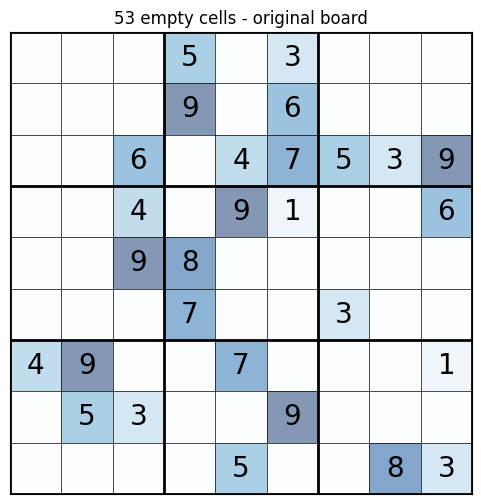

Iterations: 12628
Execution time: 0.78s

No correct solution found. Best solution:


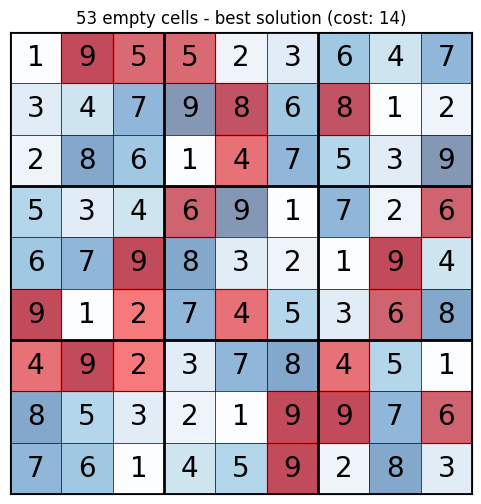

Cost: 14


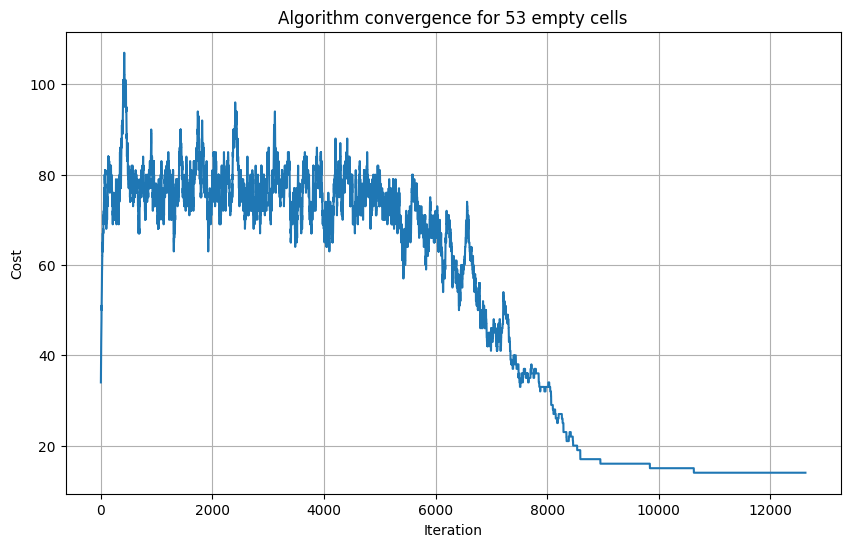


File: ./boards/1.txt
Empty cell amount: 23
Original board:


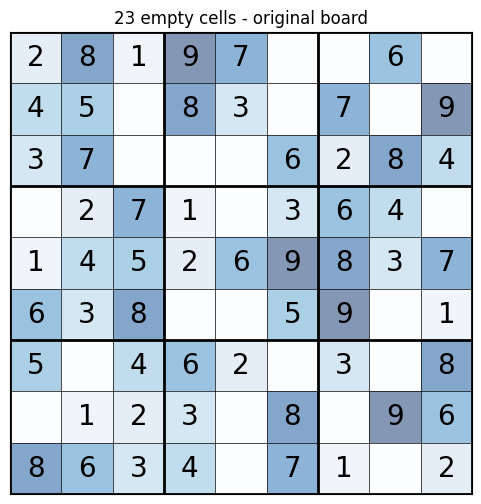

Iterations: 10079
Execution time: 0.61s

No correct solution found. Best solution:


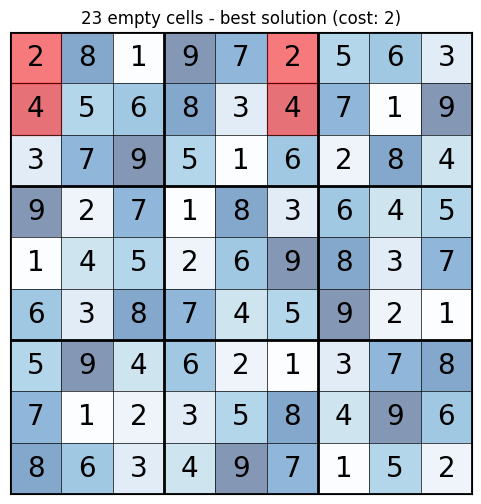

Cost: 2


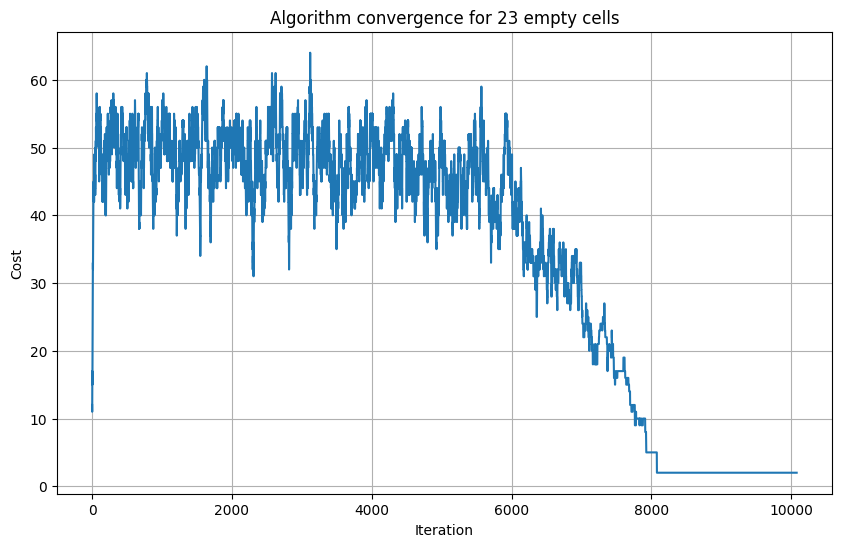


File: ./boards/2.txt
Empty cell amount: 38
Original board:


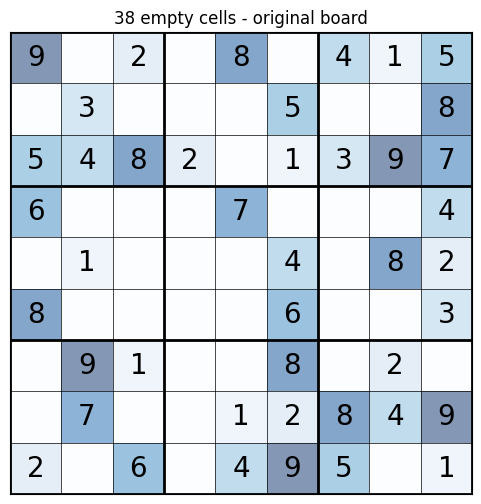

Iterations: 12372
Execution time: 0.74s

No correct solution found. Best solution:


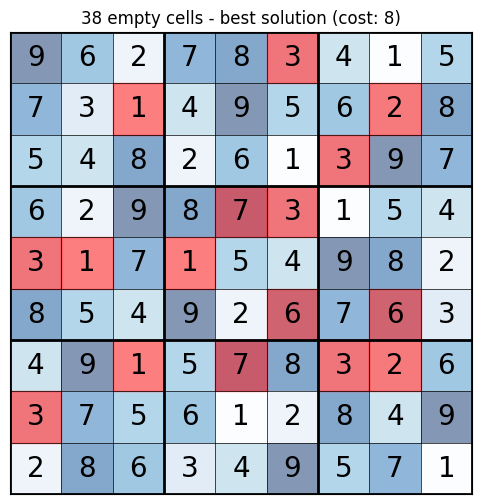

Cost: 8


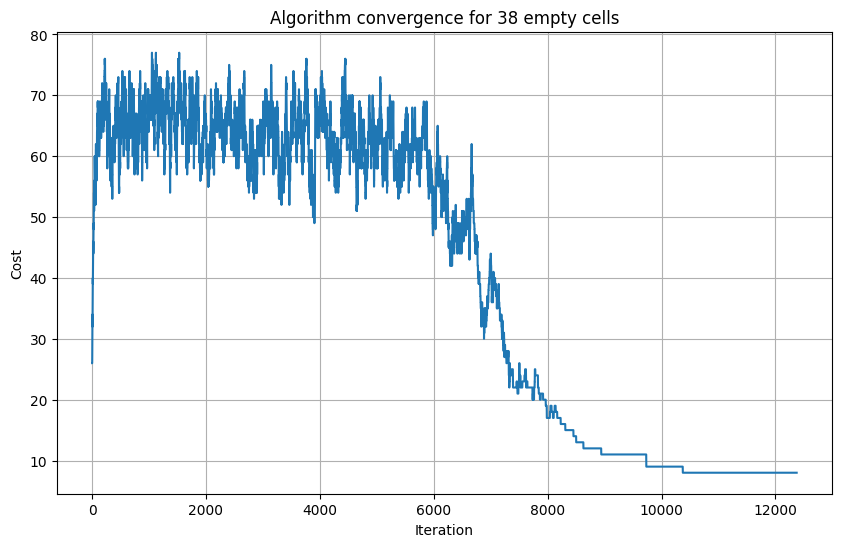


File: ./boards/3.txt
Empty cell amount: 45
Original board:


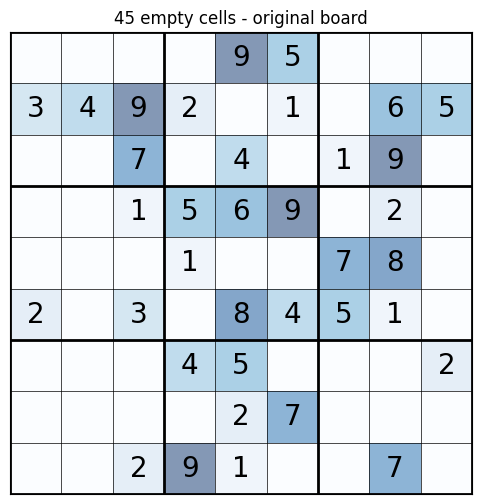

Iterations: 12148
Execution time: 0.73s

No correct solution found. Best solution:


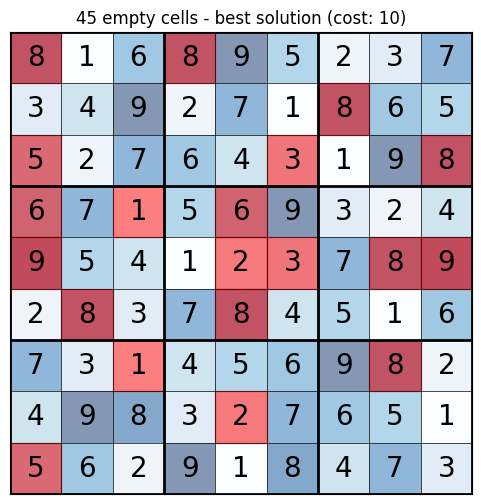

Cost: 10


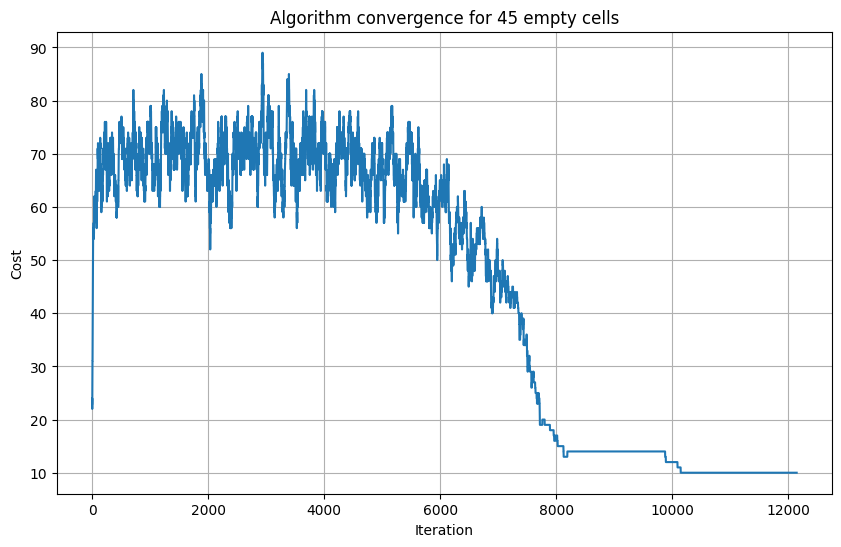


File: ./boards/4.txt
Empty cell amount: 59
Original board:


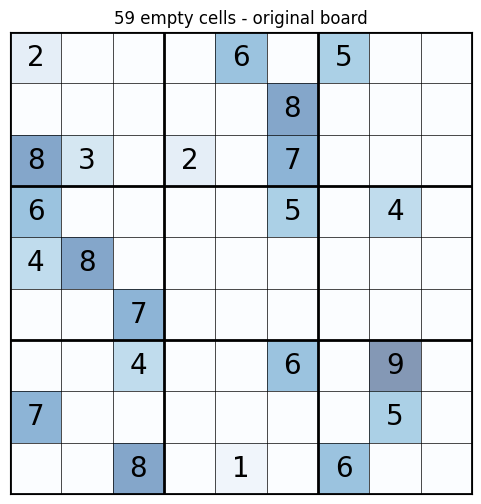

Iterations: 12173
Execution time: 0.74s

No correct solution found. Best solution:


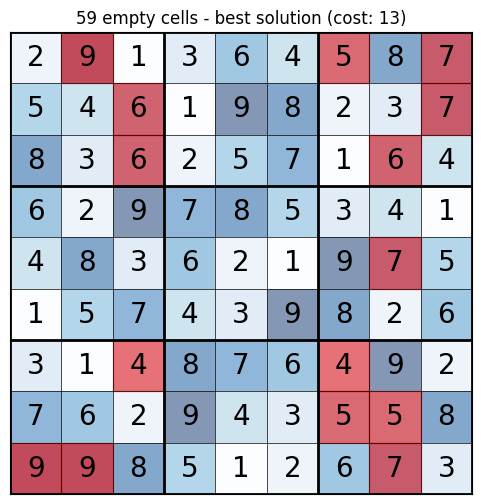

Cost: 13


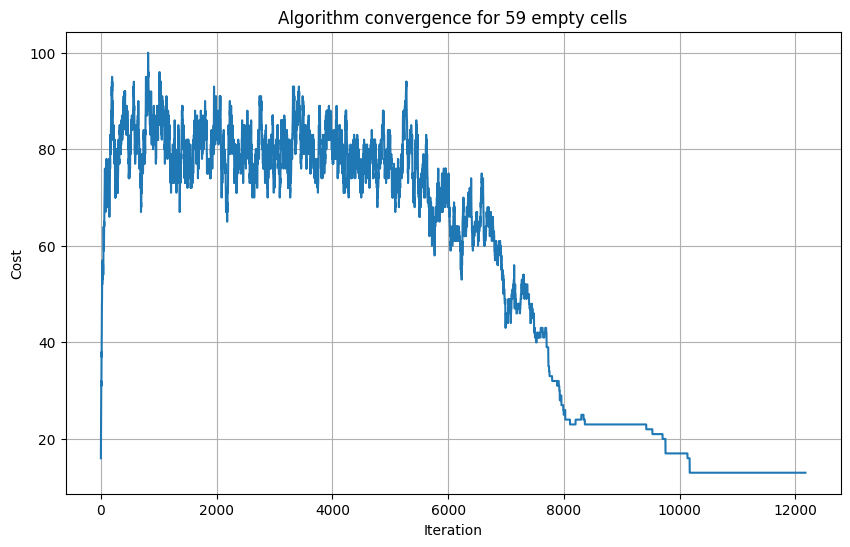


File: ./boards/5.txt
Empty cell amount: 50
Original board:


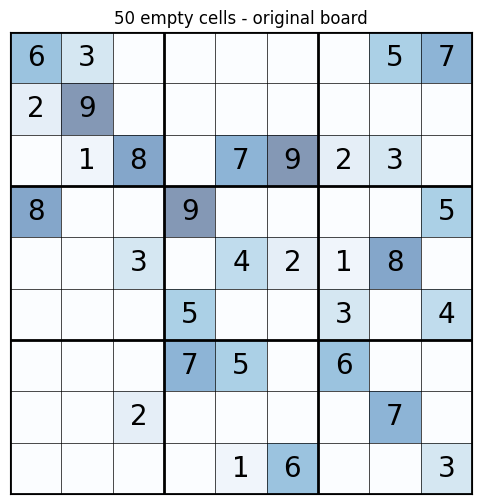

Iterations: 10968
Execution time: 0.66s

No correct solution found. Best solution:


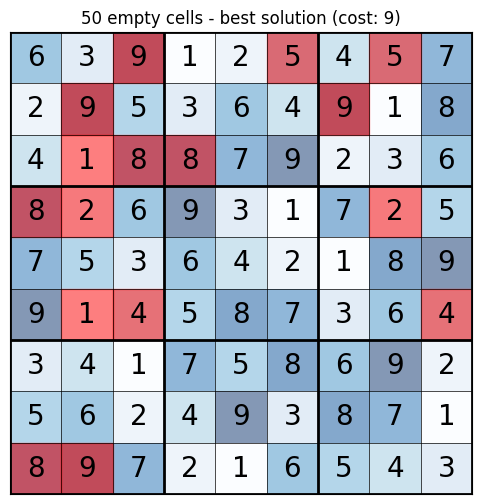

Cost: 9


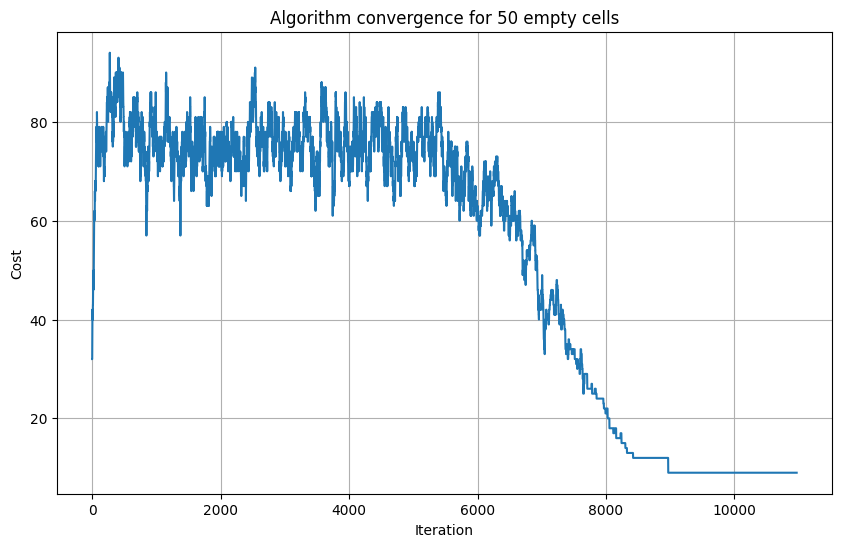


File: ./boards/6.txt
Empty cell amount: 49
Original board:


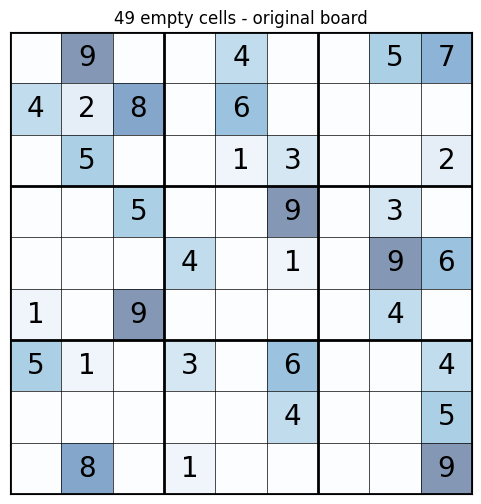

Iterations: 12138
Execution time: 0.75s

No correct solution found. Best solution:


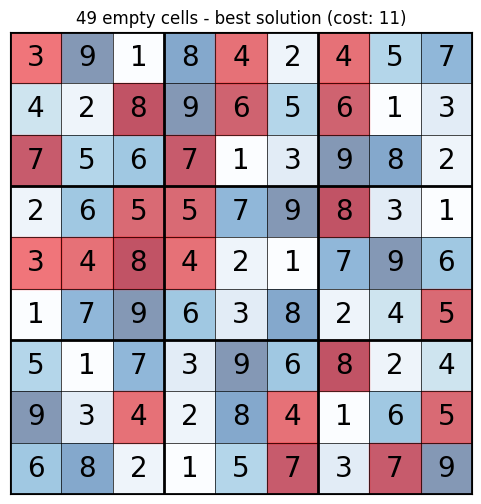

Cost: 11


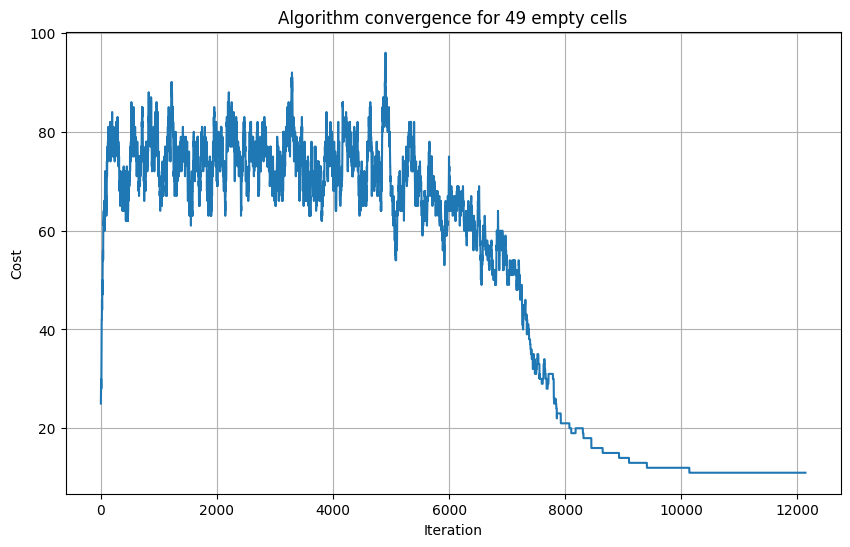


File: ./boards/7.txt
Empty cell amount: 28
Original board:


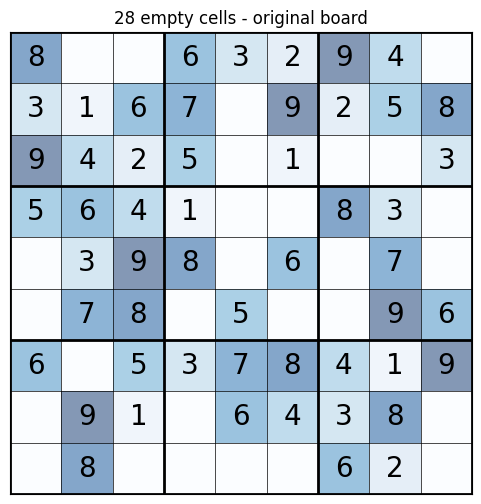

Iterations: 10527
Execution time: 0.64s

No correct solution found. Best solution:


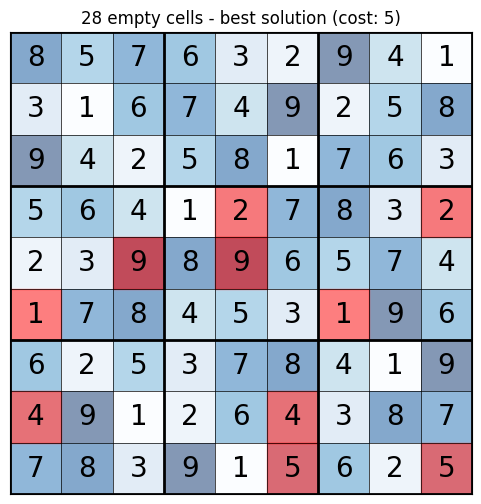

Cost: 5


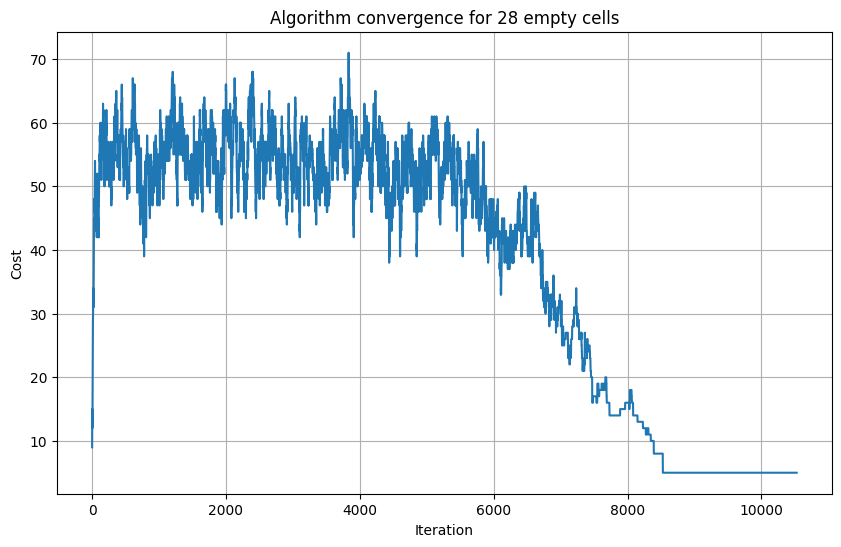


File: ./boards/8.txt
Empty cell amount: 35
Original board:


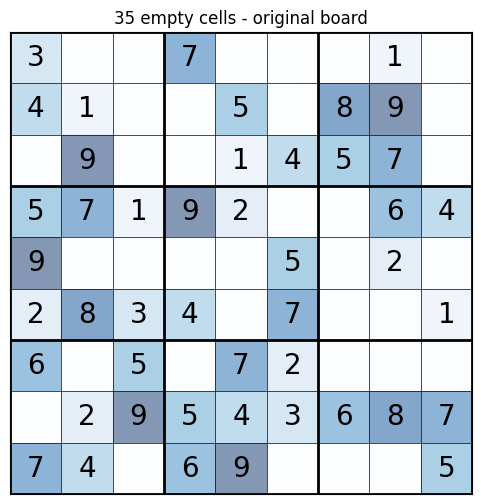

Iterations: 10574
Execution time: 0.64s

No correct solution found. Best solution:


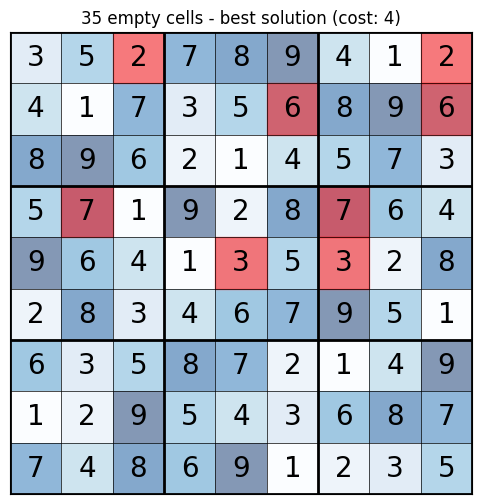

Cost: 4


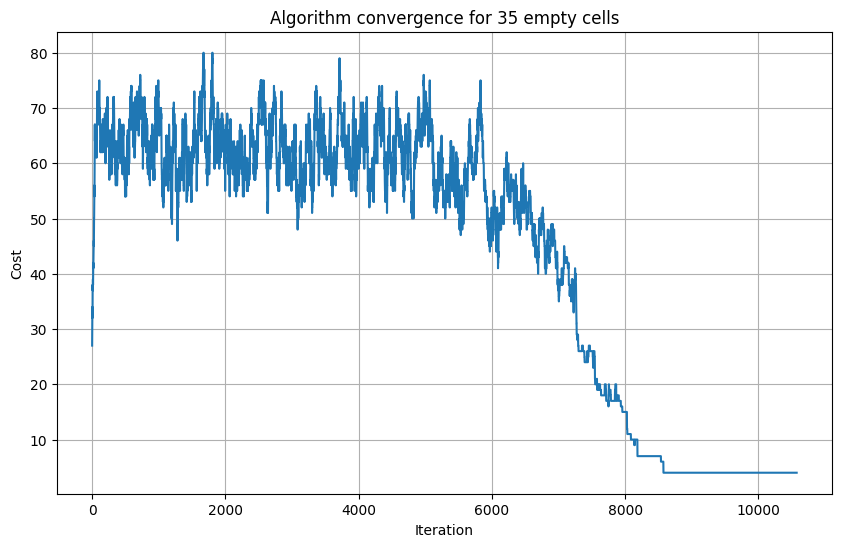


File: ./boards/9.txt
Empty cell amount: 52
Original board:


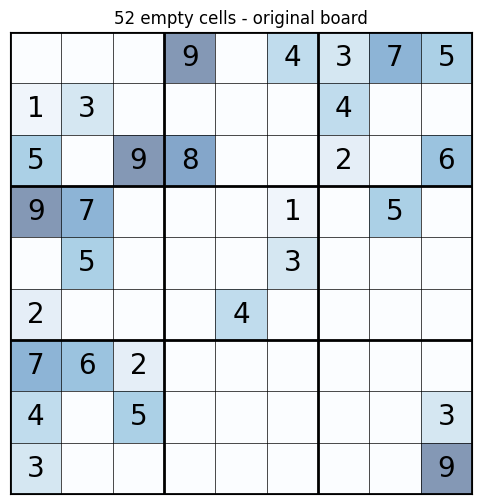

Iterations: 12312
Execution time: 0.74s

No correct solution found. Best solution:


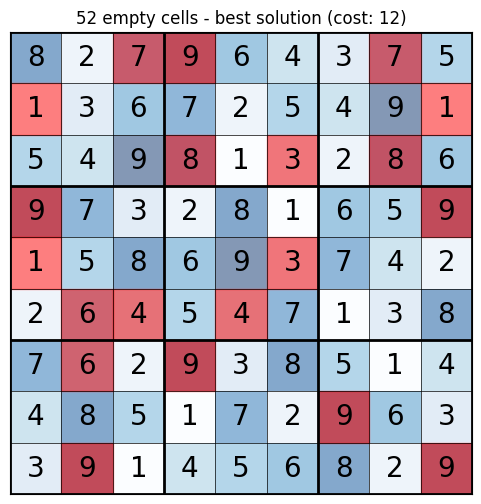

Cost: 12


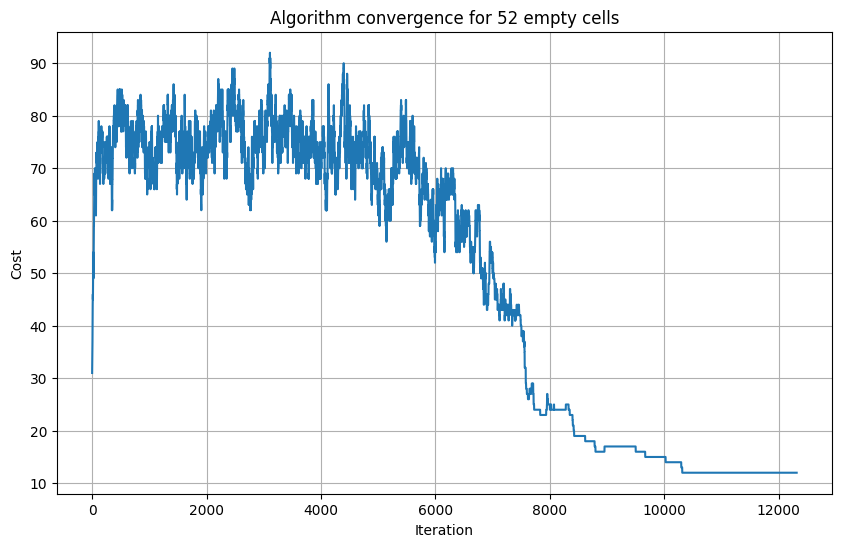


File: ./boards/10.txt
Empty cell amount: 54
Original board:


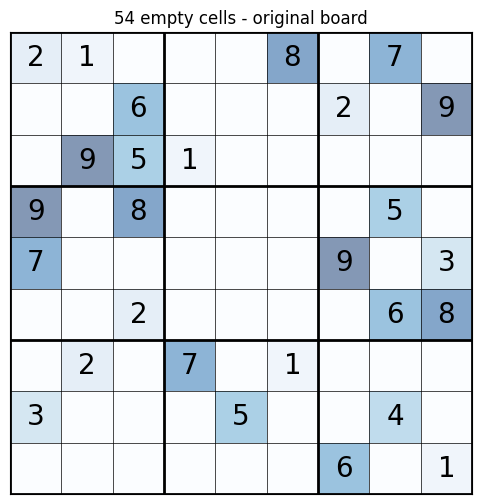

Iterations: 14912
Execution time: 0.99s

No correct solution found. Best solution:


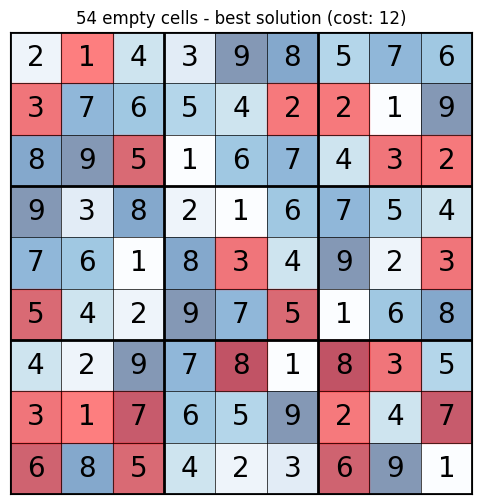

Cost: 12


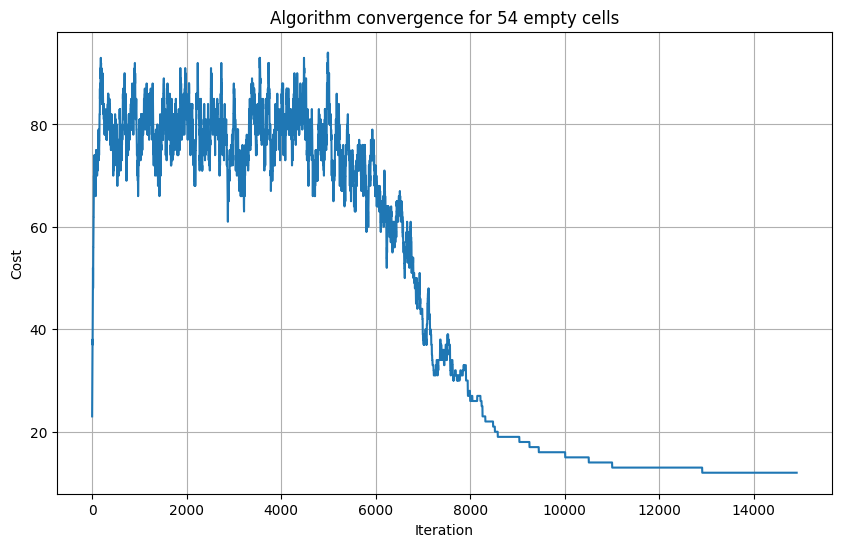


File: ./boards/11.txt
Empty cell amount: 57
Original board:


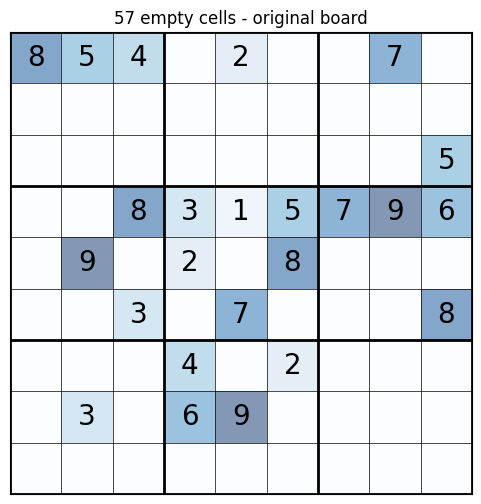

Iterations: 12860
Execution time: 0.78s

No correct solution found. Best solution:


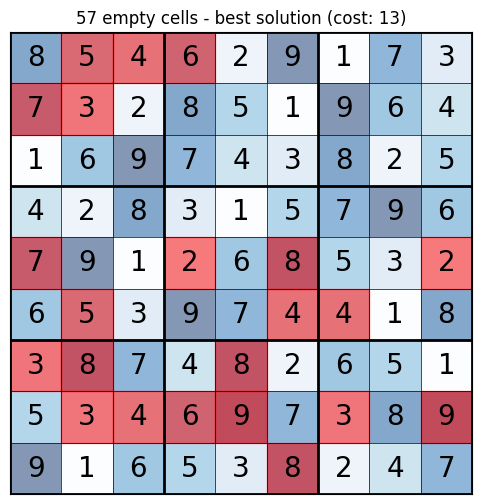

Cost: 13


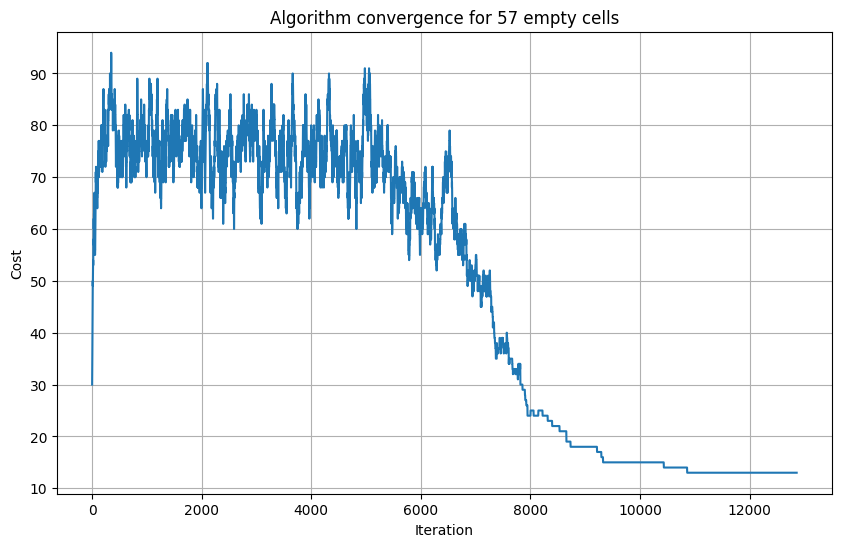


File: ./boards/12.txt
Empty cell amount: 25
Original board:


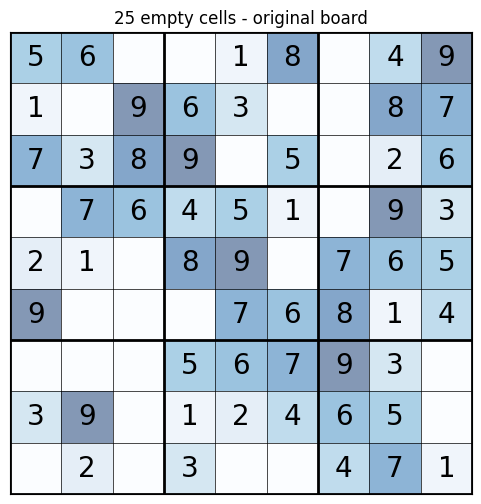

Iterations: 0
Execution time: 0.00s

Found solution:


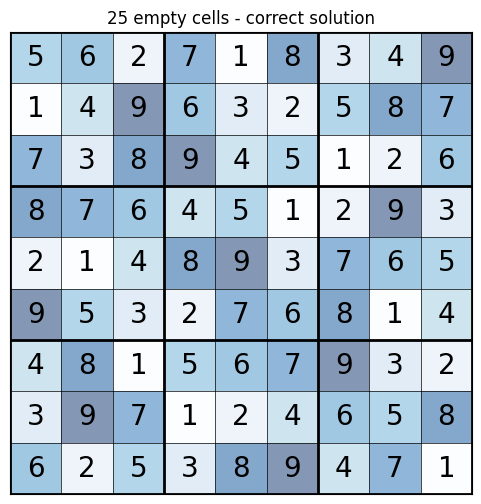

Correct solution found while initializing the board.

File: ./boards/13.txt
Empty cell amount: 54
Original board:


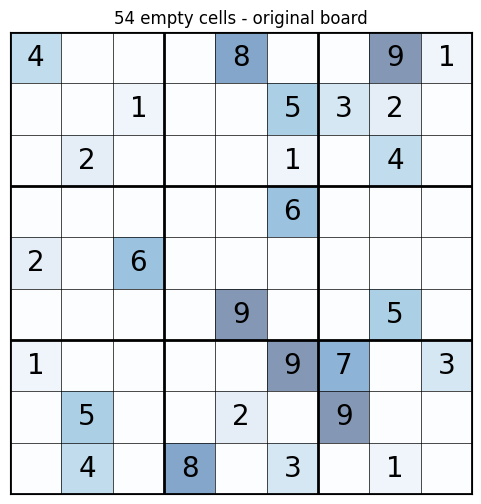

Iterations: 12767
Execution time: 0.78s

No correct solution found. Best solution:


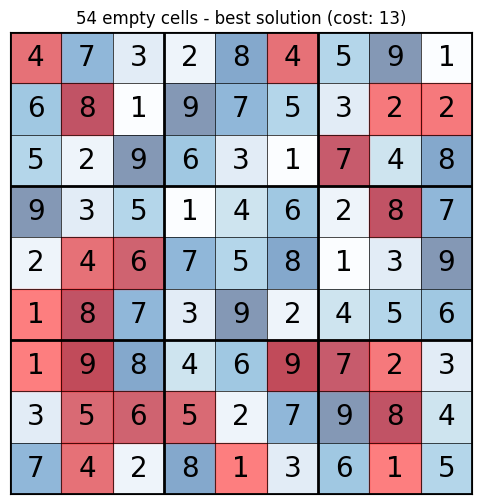

Cost: 13


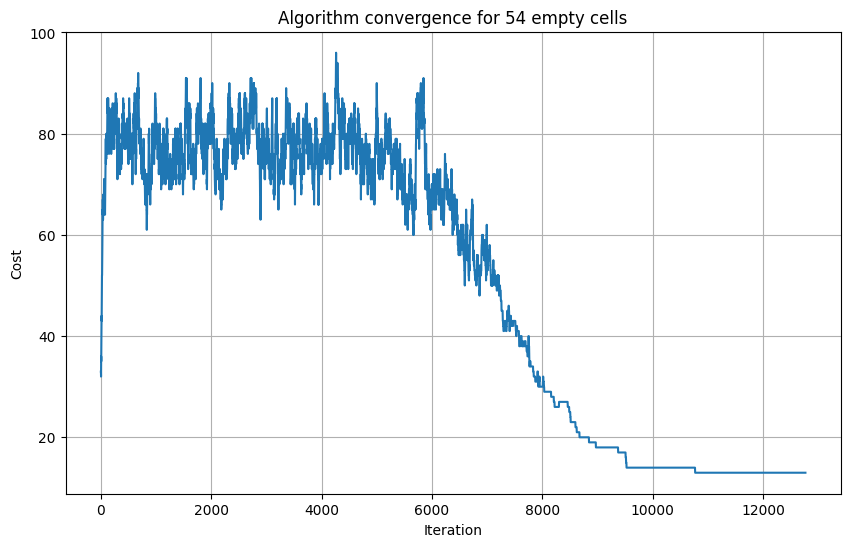


File: ./boards/14.txt
Empty cell amount: 30
Original board:


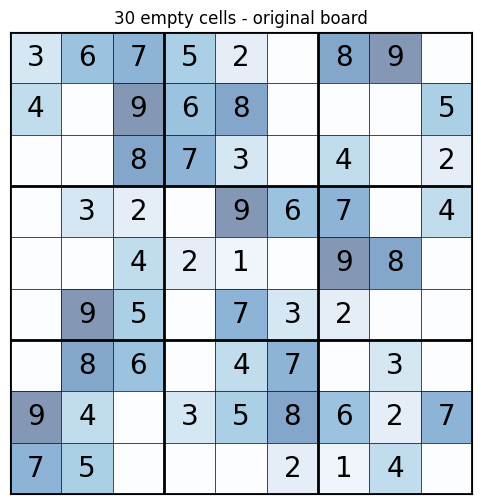

Iterations: 10168
Execution time: 0.60s

No correct solution found. Best solution:


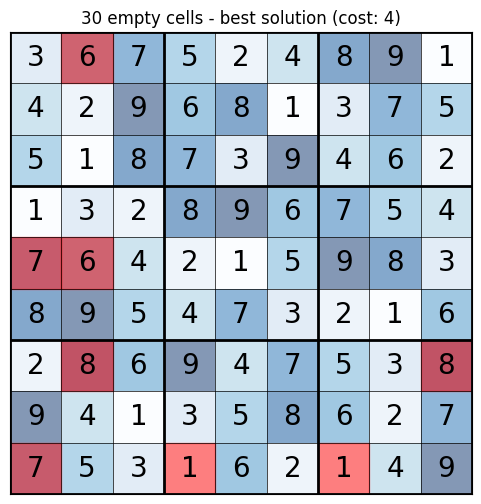

Cost: 4


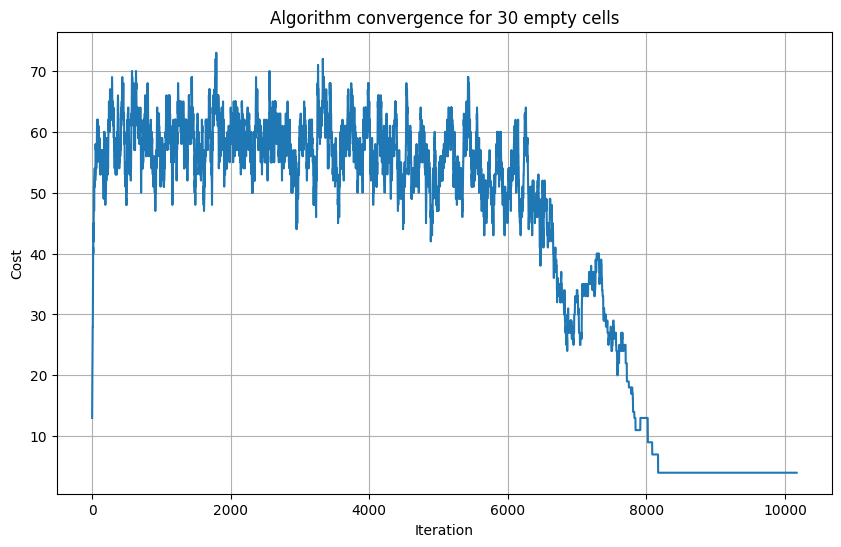


File: ./boards/15.txt
Empty cell amount: 48
Original board:


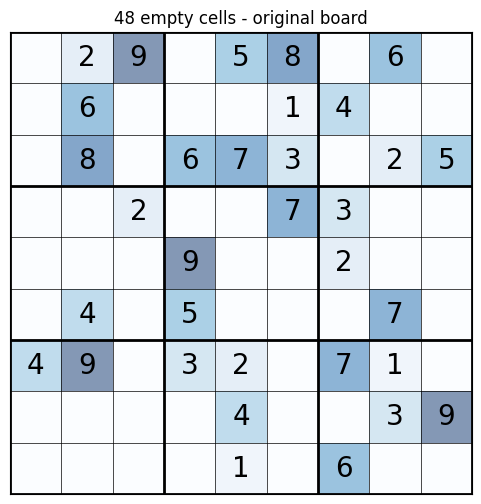

Iterations: 12024
Execution time: 0.74s

No correct solution found. Best solution:


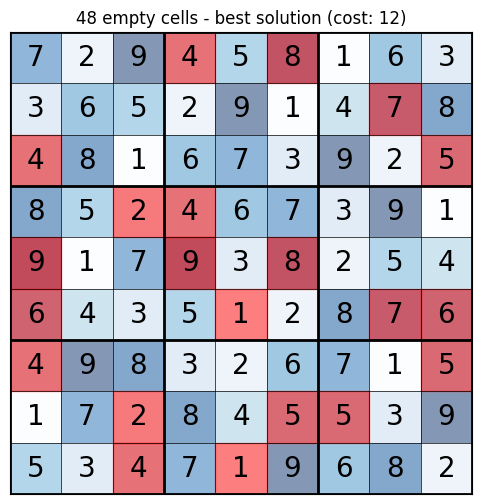

Cost: 12


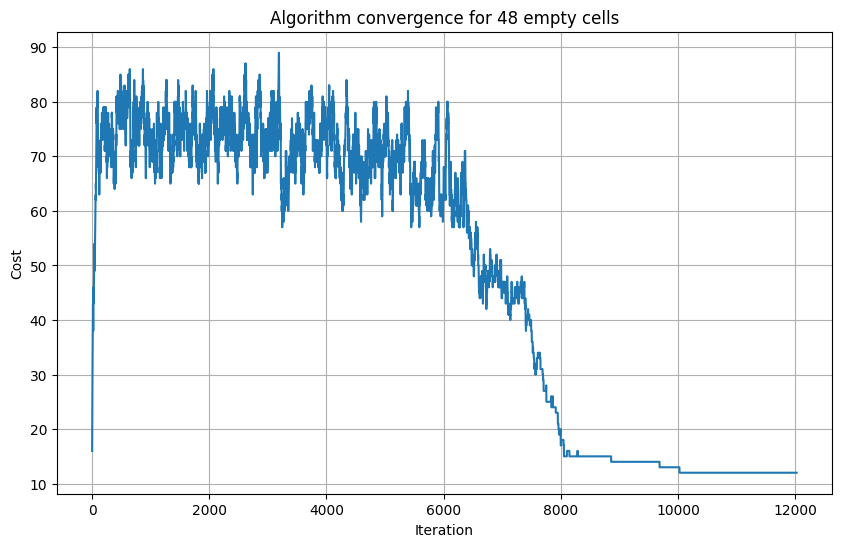


File: ./boards/16.txt
Empty cell amount: 54
Original board:


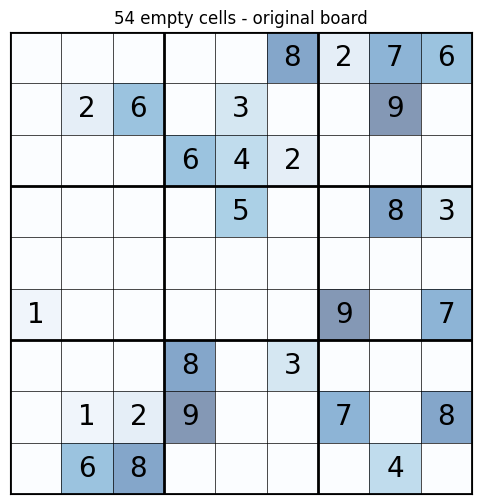

Iterations: 16028
Execution time: 0.97s

No correct solution found. Best solution:


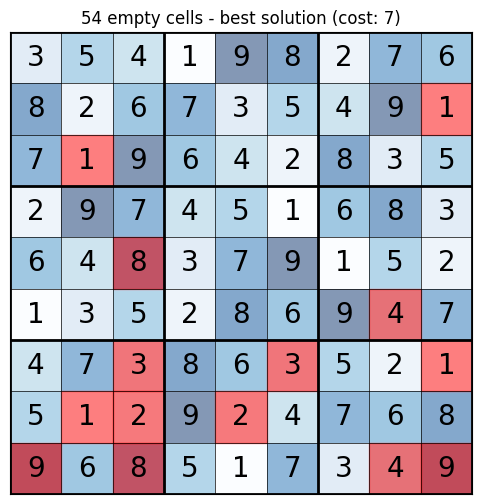

Cost: 7


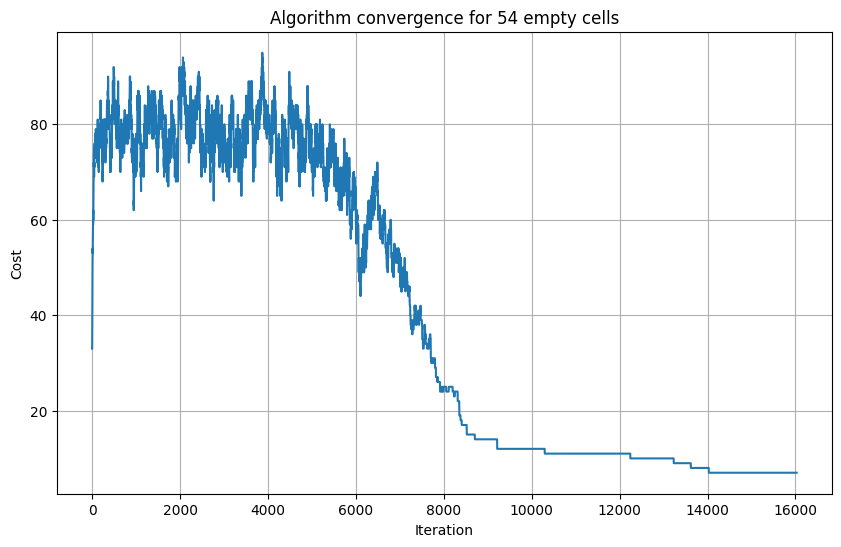


File: ./boards/17.txt
Empty cell amount: 28
Original board:


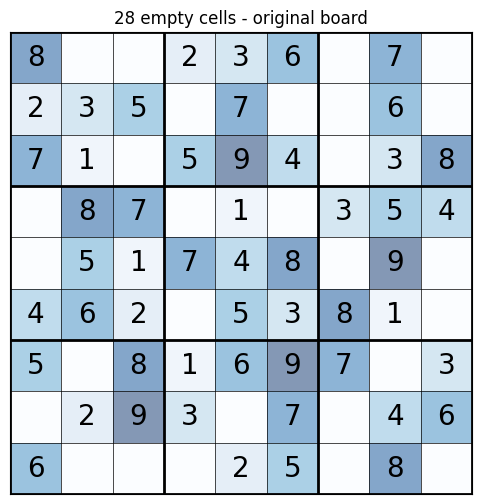

Iterations: 7952
Execution time: 0.50s

Found solution:


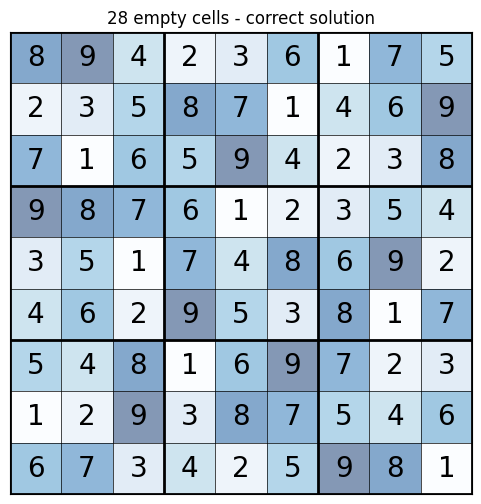

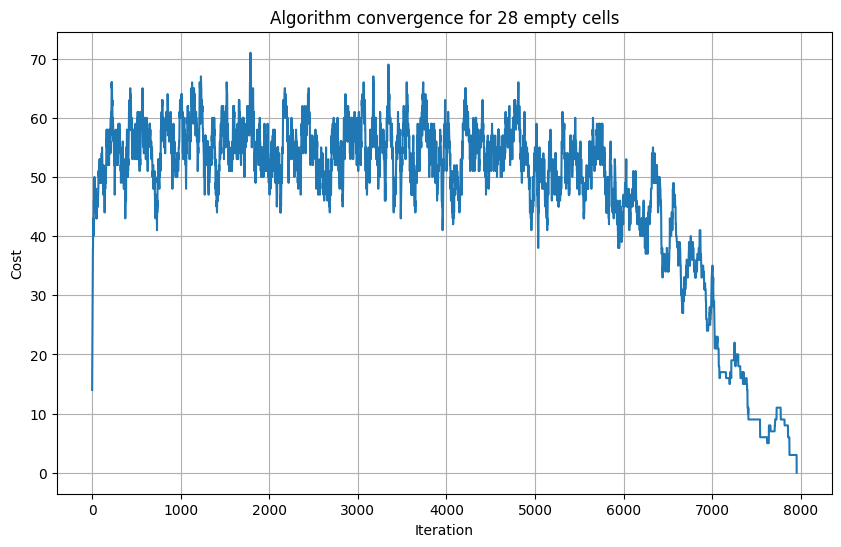


File: ./boards/18.txt
Empty cell amount: 34
Original board:


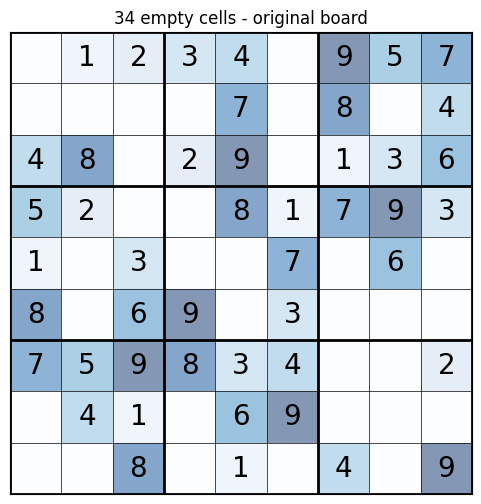

Iterations: 10858
Execution time: 0.66s

No correct solution found. Best solution:


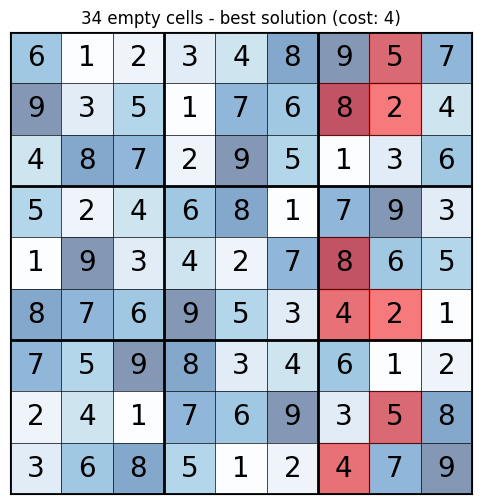

Cost: 4


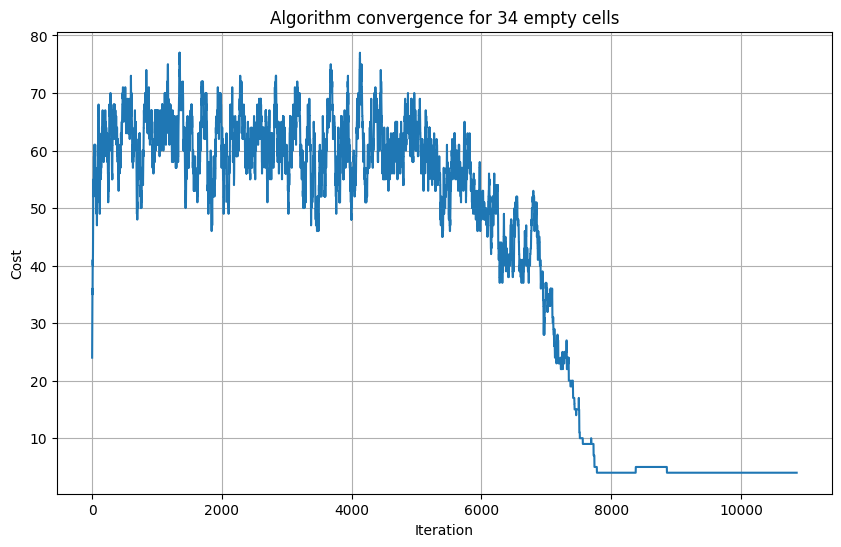


File: ./boards/19.txt
Empty cell amount: 49
Original board:


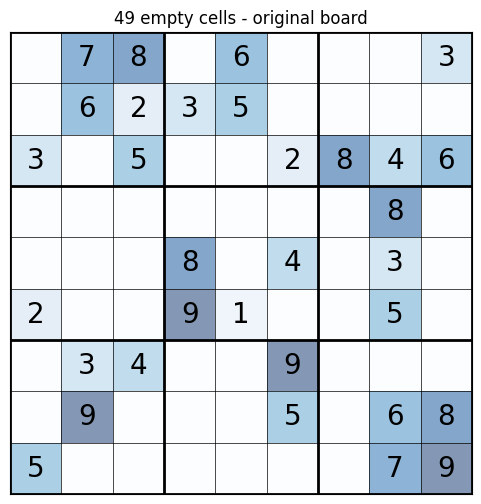

Iterations: 10391
Execution time: 0.63s

No correct solution found. Best solution:


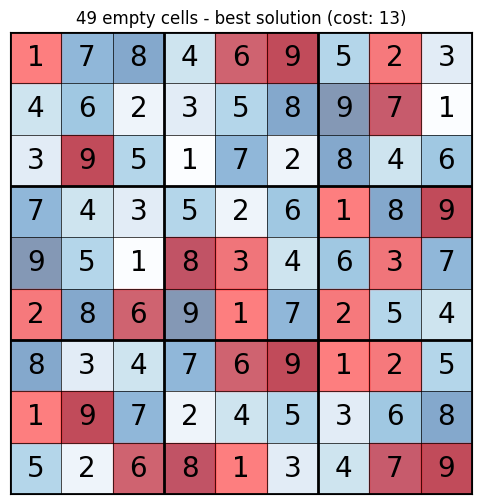

Cost: 13


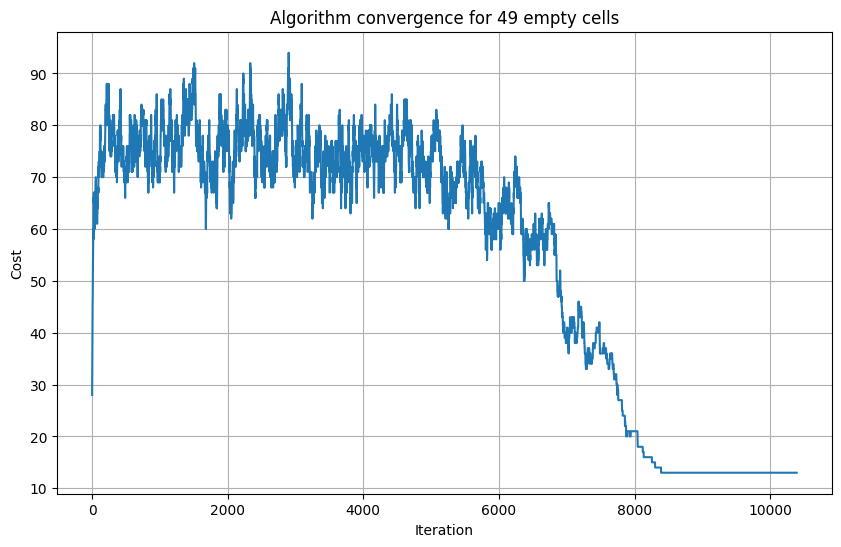

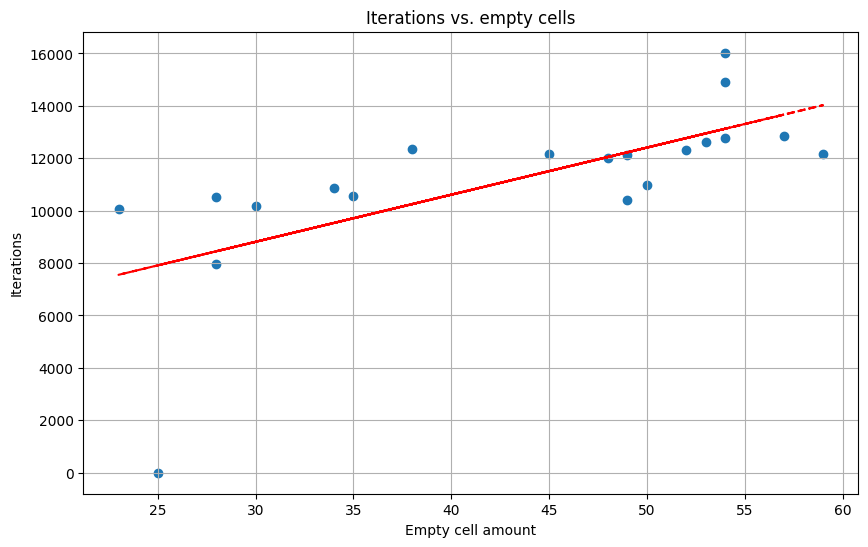

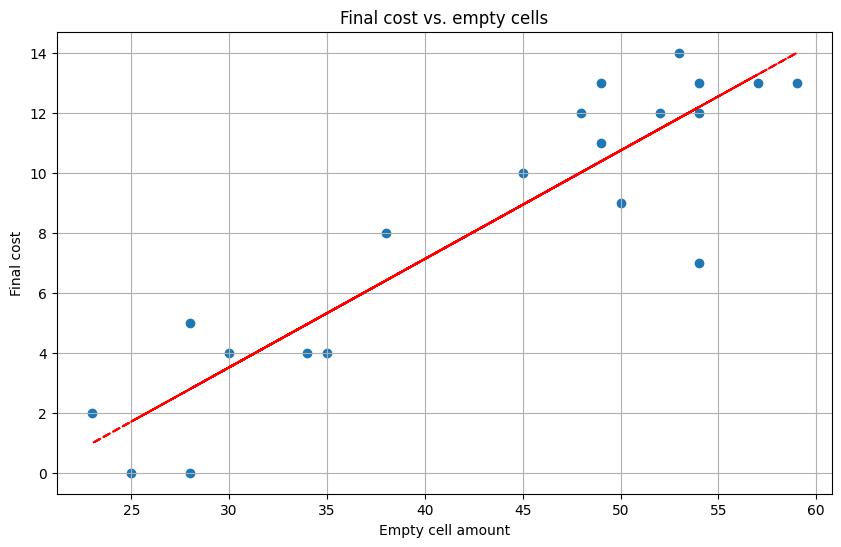

In [9]:
test_files = []
results = []

for name in range(20):
    test_files.append(f"./boards/{name}.txt")

for file_path in test_files:
    original_board = load_board(file_path)
    empty_cells = find_empty_cells(original_board)
    empty_count = len(empty_cells)

    solution, iterations, iter_history, cost_hist, el_time =\
        simulated_annealing(original_board, empty_cells)

    final_cost = calculate_cost(solution)
    valid_solution = final_cost == 0
    results.append({
        'final_cost': final_cost,
        'empty_count': empty_count,
        'iterations': iterations,
    })

    print(f"\nFile: {file_path}")
    print(f"Empty cell amount: {empty_count}")
    print("Original board:")

    plot_board(original_board, f"{empty_count} empty cells - original board")

    print(f"Iterations: {iterations}")
    print(f"Execution time: {el_time:.2f}s")

    if valid_solution:
        print("\nFound solution:")

        plot_board(solution, f"{empty_count} empty cells - correct solution")

    else:
        print("\nNo correct solution found. Best solution:")

        plot_board(solution, f"{empty_count} empty cells - best solution (cost: {final_cost})")

        print(f"Cost: {final_cost}")

    if len(iter_history) > 0:
        plot_convergence(iter_history, cost_hist, empty_count)
    else:
        print("Correct solution found while initializing the board.")

final_costs = [r['final_cost'] for r in results]
empty_counts = [r['empty_count'] for r in results]
iteration_counts = [r['iterations'] for r in results]

plot_vs_empty_cells(iteration_counts, empty_counts, 'Iterations')
plot_vs_empty_cells(final_costs, empty_counts, 'Final cost')

### 5. Wnioski

#### 1. Liczba pustych pól a liczba iteracji
- Liczba pustych pól ma niewielki wpływ na liczbę iteracji algorytmu.
- Można zaobserwować niewielką tendencję wzrostową liczby iteracji wraz z wzrostem liczby pustych pól, jednak różnice nie są znaczące.

#### 2. Liczba pustych pól a końcowy koszt
- Końcowy koszt rozwiązania w dużym stopniu zależy od liczby pustych pól - wyraźna tendencja wzrostowa.
- Dla mało złożonych plansz (<30 pustych pól) algorytm znajduje rozwiązania niemal poprawne, o koszcie bliskim zeru.
- Dla plansz o większym stopniu trudności (>45 pustych pól) rozwiązania oddalają się od poprawnych.

#### 3. Czas działania
- Czas działania algorytmu umiarkowanie rośnie wraz z liczbą pustych pól, co jest skutkiem niedużych różnic w ilościach iteracji.

#### 4. Ogólne wnioski
- Algorytm sprawdza się dobrze w przypadku plansz o umiarkowanej trudności.
- Dla trudniejszych plansz skuteczność znacząco spada, przede wszystkim pod względem dokładności rozwiązania.